---
layout: notes
chapter: 2
permalink: /ml-book/chapter2/notes.html
---

## The Process
* Big Picture (Problem Statement)
* Get Data
* Exploratory Data Analysis
* Data Preparation
* Model selection and training
* Fine-tune the model
* Production
* Monitor and Maintain

## Frame the Problem

### The Task
* Build a model to predict housing prices in California given California census data. Specifically, predict the median housing price in any district, given all other metrics. 

### Additional Considerations
* Determine how exactly the result of your model is going to be used
  * In this instance it will be fed into another machine learning model downstream
  * Current process is a manual one which is costly and time consuming
  * Typical error rate of the experts is 15%
* Questions to ask yourself:
  * Is it supervised, unsupervised, or Reinforcement Learning? Supervised (because we have labels of existing median housing price
  * Is it a classification, regression or something else? It's a regression task, we're predicting a number
  * Should you use batch learning or online learning? Depends on the volume of data, but probably batch learning.

## RMSE (Root Mean Squared Error)
Measures the standard deviation of the errors the system makes in its predictions. Recall the standard deviation is:

$$ \sigma = \sqrt{\frac{\sum_{i}{(\bar{X} - X_i)^2}}{N}} $$

Analogously RMSE is:

$$ RMSE = \sqrt{\frac{\sum_{i}{(y_i - f(X_i))^2}}{N}} $$

where $f$ is our model. There is also Mean Absolute Error (MAE). RMSE is more 
sensitive to outliers than MAE because for large outliers (i.e. differences) 
RMSE will make them larger by squaring them.

## Get the Data

In [1]:
import tarfile
import tempfile
import urllib.request
import os
import pandas as pd

housing_url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

def read_tar(url):
    r = urllib.request.urlopen(url)
    with tempfile.TemporaryDirectory() as d:
        with tarfile.open(fileobj=r, mode="r:gz") as tf:
            tf.extractall(path=d)
            name = tf.getnames()[0]
        df = pd.read_csv(os.path.join(d, name))
    return df

df = read_tar(housing_url)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


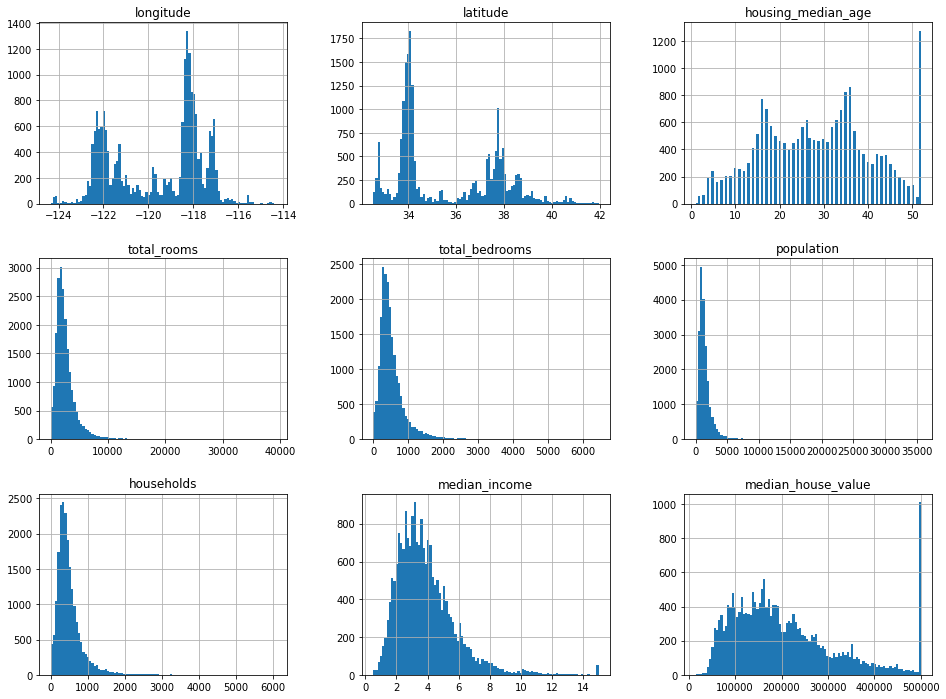

In [5]:
# Show histogram of the features
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=100, figsize=(16,12));

In [12]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000
